In [120]:
# Import libraries
import psutil
import pandas as pd
import numpy as np
from fuzzywuzzy import process, fuzz
import glob
import time
import boto3
import os

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False)
import seaborn as sns
import matplotlib.pyplot as plt

import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# import statistics
# from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings('ignore')

### Load cleaned data

In [ ]:
psutil.virtual_memory()

In [ ]:
# Read in commentors
commentors = pd.read_csv('data/cleaned/comments.csv', usecols=['commentor'])

### Resolve commentors suspected to be the same individual

In [ ]:
# number of unique commentors
commentors.commentor.nunique()

In [ ]:
# get an example of a potential single commentor under two different usernames
commentors[commentors.commentor.str.contains("All Eyez On Me")]['commentor'].unique()

In [ ]:
# get another example
commentors[commentors.commentor.str.contains("Native Americans")]['commentor'].unique()

In [ ]:
fuzz.partial_ratio('"All Eyez On Me" in theaters NOW!!!','"All Eyez On Me" in theaters june 16 2017')

In [ ]:
unique_commentors = pd.DataFrame(commentors.commentor.unique())
unique_commentors.columns = ['commentor']
unique_commentors = unique_commentors.sort_values(by=['commentor']).reset_index(drop=True)
df = unique_commentors[:1000]

In [ ]:
%%time

# Create df of unique commentor's usernames
unique_commentors = pd.DataFrame(commentors.commentor.unique())
unique_commentors.columns = ['commentor']
unique_commentors = unique_commentors.sort_values(by=['commentor']).reset_index(drop=True)

increment = 1000
for i in range(0,round(unique_commentors.shape[0]), increment):
    start_time = time.time()
    print(i)
    df = unique_commentors[i:i+increment]

    # Compare usernames to find potential split entities
    potential_matches = list()
    for name in df.commentor:
        if len(name) < 10:
            continue
        for other_name in df.commentor:
            if name != other_name and len(other_name) > 10:
                score = fuzz.partial_ratio(name, other_name)
                if score >= 83:
                    potential_matches.append([name,other_name,score])

    potential_matches_df = pd.DataFrame(potential_matches, columns=['username1','username2','score'])
    potential_matches_df.to_csv(f'tmp_entity_resolution/{i}.csv', header=False, index=False)
    print(time.time() - start_time)

In [ ]:
# Read in resolved usernames
resolved_usernames_files = glob.glob('tmp_entity_resolution/*.csv')
data = list()

for filename in resolved_usernames_files:
    df = pd.read_csv(filename, names=['commentor1','commentor2','score'])
    data.append(df)

resolved_usernames = pd.concat(data, axis=0, ignore_index=True)
resolved_usernames.shape

In [ ]:
# Calculate various ratios
resolved_usernames['ratio'] = resolved_usernames.apply(lambda x: fuzz.ratio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['partial_token_set_ratio'] = resolved_usernames.apply(lambda x: fuzz.partial_token_set_ratio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['token_sort_ratio'] = resolved_usernames.apply(lambda x: fuzz.token_sort_ratio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['WRatio'] = resolved_usernames.apply(lambda x: fuzz.WRatio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['avg_score'] = resolved_usernames[['score', 'ratio','partial_token_set_ratio','token_sort_ratio']].mean(axis=1)
high_confidence_matches = resolved_usernames[resolved_usernames.WRatio >= 88]
high_confidence_matches.to_csv('tmp_resolved_entities/high_confidence_matches.csv', header=True, index=False)

In [ ]:
# example of a potential single commentor operating under different usernames 
high_confidence_matches[high_confidence_matches.commentor1 == 'joetoronto'].head()

In [ ]:
# Create mapping between duplicate name and resolved name
resolved_commentors = dict()
for i in range(0, len(high_confidence_matches)):
    commentor1 = high_confidence_matches['commentor1'].iloc[i]
    commentor2 = high_confidence_matches['commentor2'].iloc[i]
    if commentor2 not in resolved_commentors.keys():
        if commentor1 not in resolved_commentors.keys():
            resolved_commentors[commentor2] = commentor1

In [ ]:
resolved_commentors

In [ ]:
# Load entire comment dataset
commentors = pd.read_csv('data/cleaned/comments.csv', header=0)
commentors.head()

In [ ]:
# Map resolved usernames
commentors['commentor_resolved'] = commentors['commentor'].map(resolved_commentors)
commentors['commentor_resolved'].fillna(commentors['commentor'], inplace=True)

In [ ]:
# Inspect resolved commentors
# commentors.groupby(['commentor_resolved','commentor']).size().reset_index()
original_num_commentors = commentors['commentor'].nunique()
resolved_num_commentors = commentors['commentor_resolved'].nunique()
print(f'Original # Commentors: {original_num_commentors}')
print(f'Resolved # Commentors: {resolved_num_commentors}')
print(f'Diff: {original_num_commentors - resolved_num_commentors}')

In [ ]:
commentors.to_csv('data/cleaned/comments_w_resolved_commentor.csv', header=True, index=False)

### Upload updated dataset to S3

In [ ]:
s3 = boto3.client('s3')
bucket = 'ml-guild-project-pft-comments'
s3.upload_file('data/cleaned/comments_w_resolved_commentor.csv', bucket, 'data/cleaned/comments_w_resolved_commentor.csv')

### Split comment dataset into years

In [ ]:
psutil.virtual_memory()

In [ ]:
# Break comments dataset into individual years
commentors = pd.read_csv('data/cleaned/comments_w_resolved_commentor.csv', parse_dates=['comment_datetime_clean'])
commentors['cyear'] = commentors.comment_datetime_clean.dt.year
for year in commentors.cyear.unique():
    df = commentors[commentors.comment_datetime_clean.dt.year == year]
    df.to_csv(f'tmp_comments_by_year/comments_w_resolved_commentor_{year}.csv',header=True, index=False)

### Generate behavior features for a single year

In [36]:
df = pd.read_csv('tmp_comments_by_year/comments_w_resolved_commentor_2020.csv', parse_dates=['comment_datetime_clean'])
df.shape

(195692, 7)

In [37]:
year = 2020
[os.remove(f'tmp_features_by_year/{f}') for f in os.listdir('tmp_features_by_year/') if '.ipynb' not in f]

[None, None, None, None, None, None]

In [38]:
files

['.ipynb_checkpoints',
 'commentor_activity_duration_2020.csv',
 'commentor_total_chars_2020.csv',
 'comments_by_articles2020.csv',
 'comments_by_articles_2020.csv',
 'comments_by_time_of_day_2020.csv',
 'num_comments_2020.csv',
 'unique_articles_mulitple_comment_df_2020.csv']

In [39]:
# Calculate total # comments
num_comments = pd.DataFrame(df.groupby('commentor_resolved').size())
num_comments.columns = ['num_comments']
num_comments.to_csv(f'tmp_features_by_year/num_comments_{year}.csv', header=True, index=True)
num_comments.head()

num_comments
commentor_resolved                     
#The-Best-Fans-in-the-NFL           234
( . Y . )                            39
*Legion*                              1
-                                    14
.                                     5

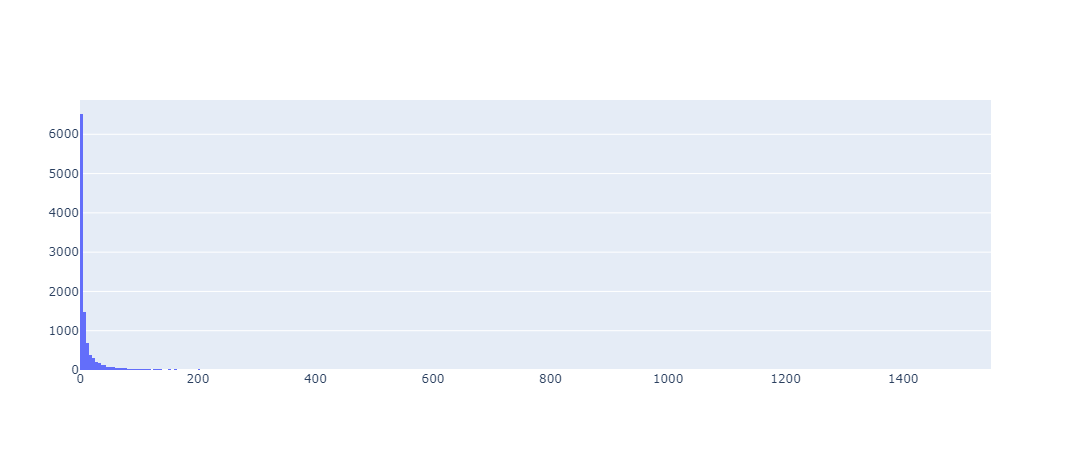

In [40]:
fig = go.Figure(data=[go.Histogram(x=num_comments.num_comments.values, histfunc='sum', histnorm='', cumulative_enabled=False)])
fig.show()

In [41]:
#2 Calculate the total number of unique articles commented on by each commenter
comments_by_articles = pd.DataFrame(df.groupby('commentor_resolved')['article_url'].nunique())
comments_by_articles.columns = ['unique_articles_commented_on']
comments_by_articles.to_csv(f'tmp_features_by_year/comments_by_articles_{year}.csv', header=True, index=True)
comments_by_articles.head()

unique_articles_commented_on
commentor_resolved                                     
#The-Best-Fans-in-the-NFL                           205
( . Y . )                                            35
*Legion*                                              1
-                                                    14
.                                                     5

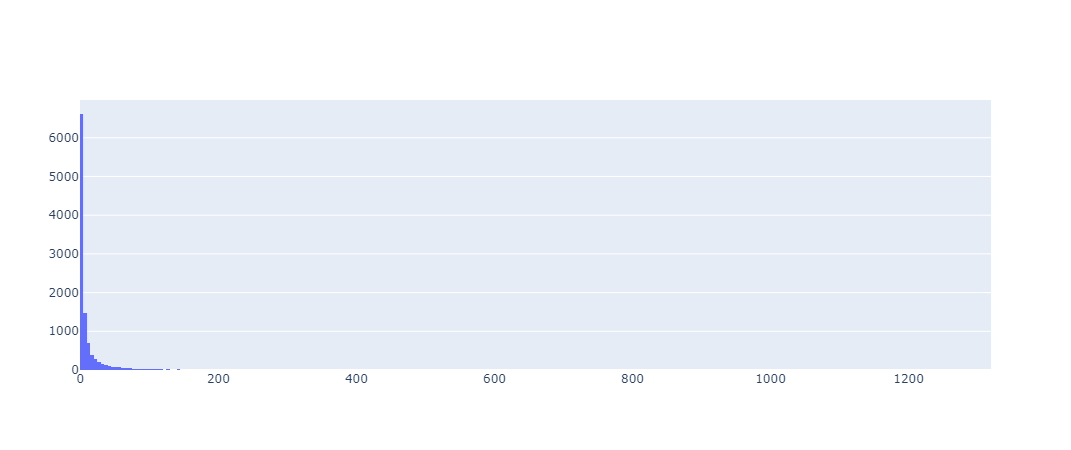

In [42]:
fig = go.Figure(data=[go.Histogram(x=comments_by_articles.unique_articles_commented_on.values, histfunc='sum', histnorm='', cumulative_enabled=False)])
fig.show()

In [43]:
#3 Calculate the time of day commenters posted
def times_of_date_by_hour(hour):
    if hour >= 5 and hour < 12:
        return 'morning'
    if hour >= 12 and hour < 17:
        return 'afternoon'
    if hour >= 17 and hour < 21:
        return 'evening'
    if hour >= 21 or hour < 5:
            return 'night'
    
df['comment_time_of_day'] = df.comment_datetime_clean.dt.hour.apply(times_of_date_by_hour)
comments_by_time_of_day = pd.pivot_table(df[['article_url','comment_time_of_day','commentor_resolved']],
                                         index=['commentor_resolved'],
                                         columns=['comment_time_of_day'],
                                         aggfunc='count',
                                         fill_value=0
                                        )
comments_by_time_of_day.columns = comments_by_time_of_day.columns.droplevel()
comments_by_time_of_day.columns = [f'comments_made_during_{c}' for c in comments_by_time_of_day.columns]
comments_by_time_of_day.to_csv(f'tmp_features_by_year/comments_by_time_of_day_{year}.csv', header=True, index=True)
comments_by_time_of_day.head()

comments_made_during_afternoon  \
commentor_resolved                                          
#The-Best-Fans-in-the-NFL                             108   
( . Y . )                                              10   
*Legion*                                                1   
-                                                       4   
.                                                       2   

                           comments_made_during_evening  \
commentor_resolved                                        
#The-Best-Fans-in-the-NFL                            49   
( . Y . )                                             1   
*Legion*                                              0   
-                                                     7   
.                                                     0   

                           comments_made_during_morning  \
commentor_resolved                                        
#The-Best-Fans-in-the-NFL                            44   
( . Y . )                                            25   
*Legion*                                              0   
-                                                     1   
.                                                     2   

                           comments_made_during_night  
commentor_resolved                                     
#The-Best-Fans-in-the-NFL                          33  
( . Y . )                                           3  
*Legion*                                            0  
-                                                   2  
.                                                   1

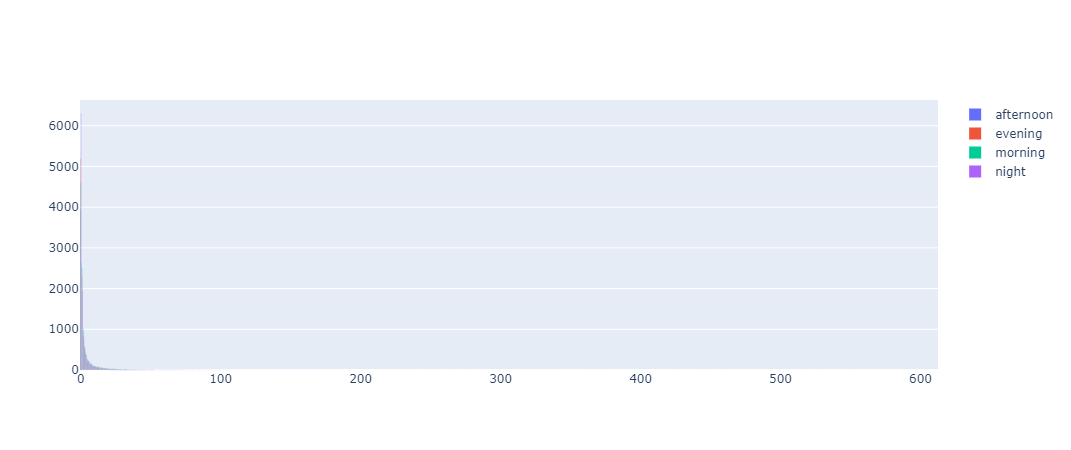

In [44]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=comments_by_time_of_day.comments_made_during_afternoon.values, name='afternoon', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_by_time_of_day.comments_made_during_evening.values, name='evening', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_by_time_of_day.comments_made_during_morning.values, name='morning', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_by_time_of_day.comments_made_during_night.values, name='night', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [45]:
#4 Calculate the number of unique articles the commentor commented on more than once
unique_articles_mulitple_comment = df.groupby(['commentor_resolved','article_url']).size()
unique_articles_mulitple_comment_df = pd.DataFrame(unique_articles_mulitple_comment)
unique_articles_mulitple_comment_df = unique_articles_mulitple_comment_df[unique_articles_mulitple_comment_df[0] > 1]

unique_articles_mulitple_comment_df = pd.DataFrame(unique_articles_mulitple_comment_df.groupby(['commentor_resolved']).size())
unique_articles_mulitple_comment_df.columns = ['number_of_articles_w_more_than_one_comment']
unique_articles_mulitple_comment_df.to_csv(f'tmp_features_by_year/unique_articles_mulitple_comment_df_{year}.csv', header=True, index=True)
unique_articles_mulitple_comment_df.head()

number_of_articles_w_more_than_one_comment
commentor_resolved                                                   
#The-Best-Fans-in-the-NFL                                          22
( . Y . )                                                           4
1 YARD SHORT                                                        1
1052thatswho                                                        1
11dannywhite                                                        1

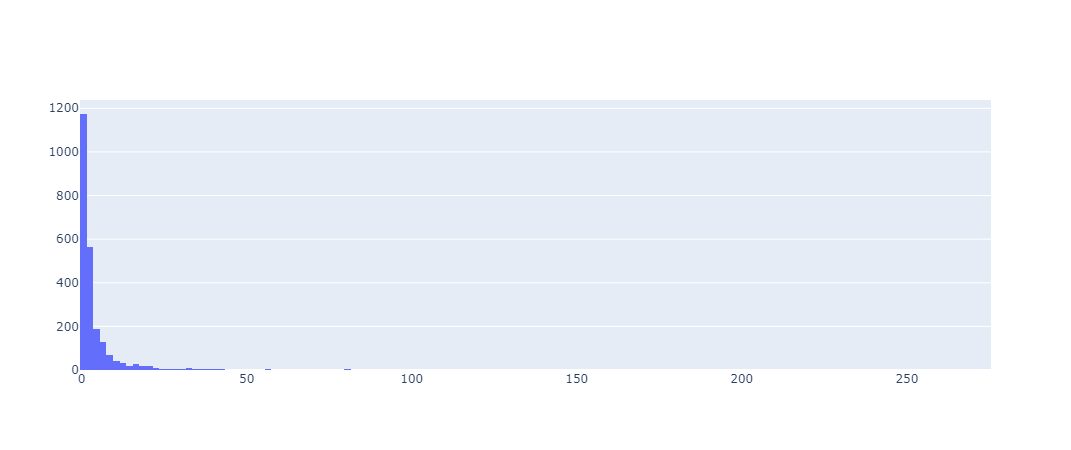

In [46]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=unique_articles_mulitple_comment_df.number_of_articles_w_more_than_one_comment, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [47]:
#5 Calculate how long (in days) a commentor has been active on pft
commentor_activity_duration = df.groupby(['commentor_resolved']).agg({'comment_datetime_clean':['min','max']})
commentor_activity_duration.columns = commentor_activity_duration.columns.droplevel()
commentor_activity_duration['commentor_activity_duration_in_days'] = (commentor_activity_duration['max'] - commentor_activity_duration['min']).dt.days
commentor_activity_duration.drop(['min','max'], axis=1, inplace=True)
commentor_activity_duration.to_csv(f'tmp_features_by_year/commentor_activity_duration_{year}.csv', header=True, index=True)
commentor_activity_duration.head()

commentor_activity_duration_in_days
commentor_resolved                                            
#The-Best-Fans-in-the-NFL                                  165
( . Y . )                                                   11
*Legion*                                                     0
-                                                          165
.                                                          248

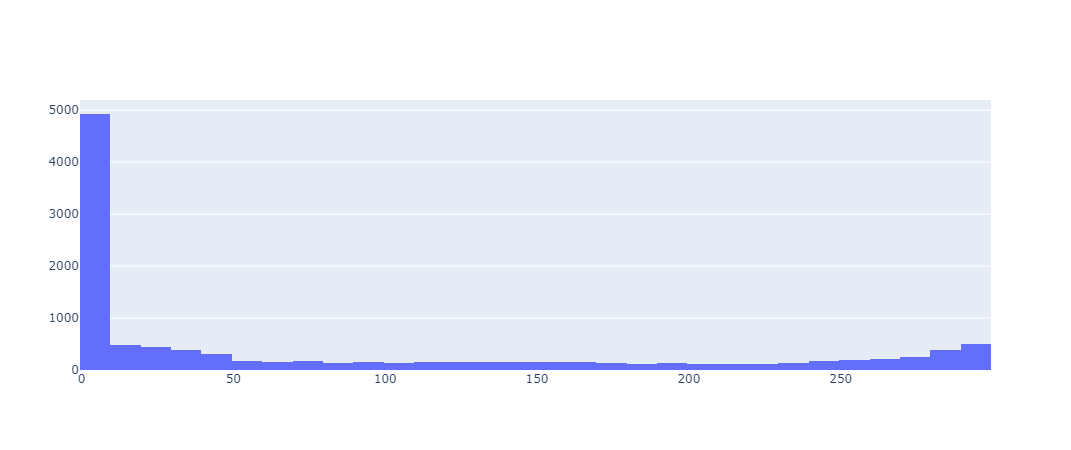

In [48]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=commentor_activity_duration.commentor_activity_duration_in_days.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [49]:
#6 Calculate the total number of characters written by the commenter
df['comment_char_len'] = df['comment_body'].str.replace('\n','').str.len()
commentor_total_chars = df.groupby(['commentor_resolved']).agg({'comment_char_len':['sum','mean']})
commentor_total_chars.columns = commentor_total_chars.columns.droplevel()
commentor_total_chars.columns = ['num_char_total','num_char_mean']
commentor_total_chars.to_csv(f'tmp_features_by_year/commentor_total_chars_{year}.csv', header=True, index=True)
commentor_total_chars.head()

num_char_total  num_char_mean
commentor_resolved                                      
#The-Best-Fans-in-the-NFL           60626     259.085470
( . Y . )                           21367     547.871795
*Legion*                              245     245.000000
-                                    1678     119.857143
.                                    2924     584.800000

### Aggregate features, scale, and DR

In [163]:
# Add the path to each feature file
feature_files = os.listdir('tmp_features_by_year/')
feature_files = [f for f in feature_files if '.ipynb' not in f]

feature_files_w_path = list()
for f in feature_files:
    feature_files_w_path.append(f'tmp_features_by_year/{f}')

# Read the first file to use as seed
df = pd.read_csv(feature_files_w_path[0], header=0, index_col=0)

# Iterate through files and merge into seed
for df_ in feature_files_w_path[1:]:
    df_next = pd.read_csv(df_, header=0, index_col=0)
    df = df.merge(df_next, on='commentor_resolved', how='left')
    
print(df.shape)

(10983, 10)


In [164]:
# Replace nans with zero
df.fillna(value=0, inplace=True)
df.head()

commentor_activity_duration_in_days  \
commentor_resolved                                               
#The-Best-Fans-in-the-NFL                                  165   
( . Y . )                                                   11   
*Legion*                                                     0   
-                                                          165   
.                                                          248   

                           num_char_total  num_char_mean  \
commentor_resolved                                         
#The-Best-Fans-in-the-NFL           60626     259.085470   
( . Y . )                           21367     547.871795   
*Legion*                              245     245.000000   
-                                    1678     119.857143   
.                                    2924     584.800000   

                           unique_articles_commented_on  \
commentor_resolved                                        
#The-Best-Fans-in-the-NFL                           205   
( . Y . )                                            35   
*Legion*                                              1   
-                                                    14   
.                                                     5   

                           comments_made_during_afternoon  \
commentor_resolved                                          
#The-Best-Fans-in-the-NFL                             108   
( . Y . )                                              10   
*Legion*                                                1   
-                                                       4   
.                                                       2   

                           comments_made_during_evening  \
commentor_resolved                                        
#The-Best-Fans-in-the-NFL                            49   
( . Y . )                                             1   
*Legion*                                              0   
-                                                     7   
.                                                     0   

                           comments_made_during_morning  \
commentor_resolved                                        
#The-Best-Fans-in-the-NFL                            44   
( . Y . )                                            25   
*Legion*                                              0   
-                                                     1   
.                                                     2   

                           comments_made_during_night  num_comments  \
commentor_resolved                                                    
#The-Best-Fans-in-the-NFL                          33           234   
( . Y . )                                           3            39   
*Legion*                                            0             1   
-                                                   2            14   
.                                                   1             5   

                           number_of_articles_w_more_than_one_comment  
commentor_resolved                                                     
#The-Best-Fans-in-the-NFL                                        22.0  
( . Y . )                                                         4.0  
*Legion*                                                          0.0  
-                                                                 0.0  
.                                                                 0.0

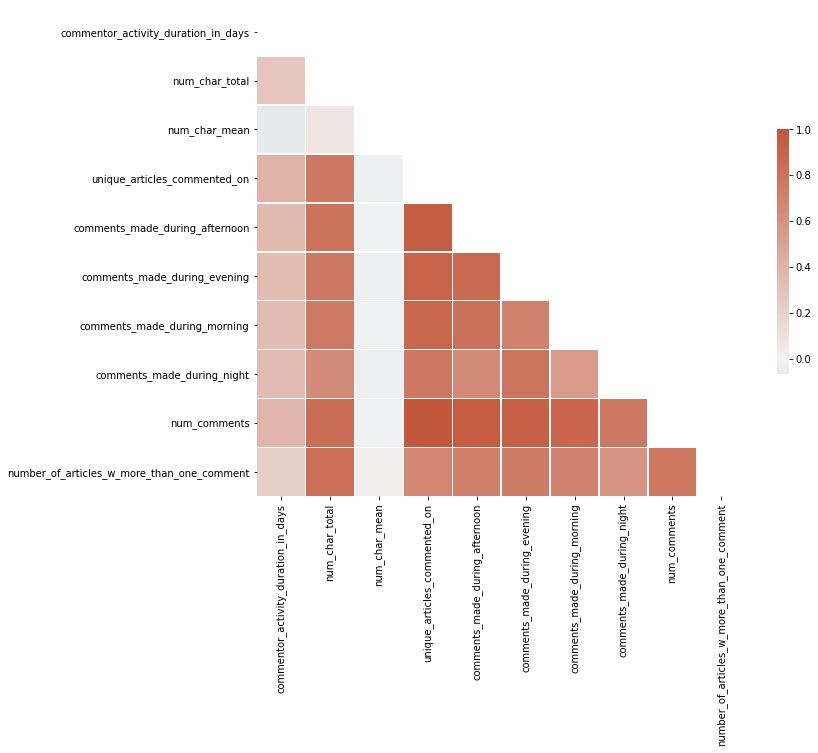

In [165]:
# Draw the heatmap with the mask and correct aspect ratio
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [166]:
# Scale features
scaler = MinMaxScaler(feature_range=[0, 1])
df_rescaled = scaler.fit_transform(df)

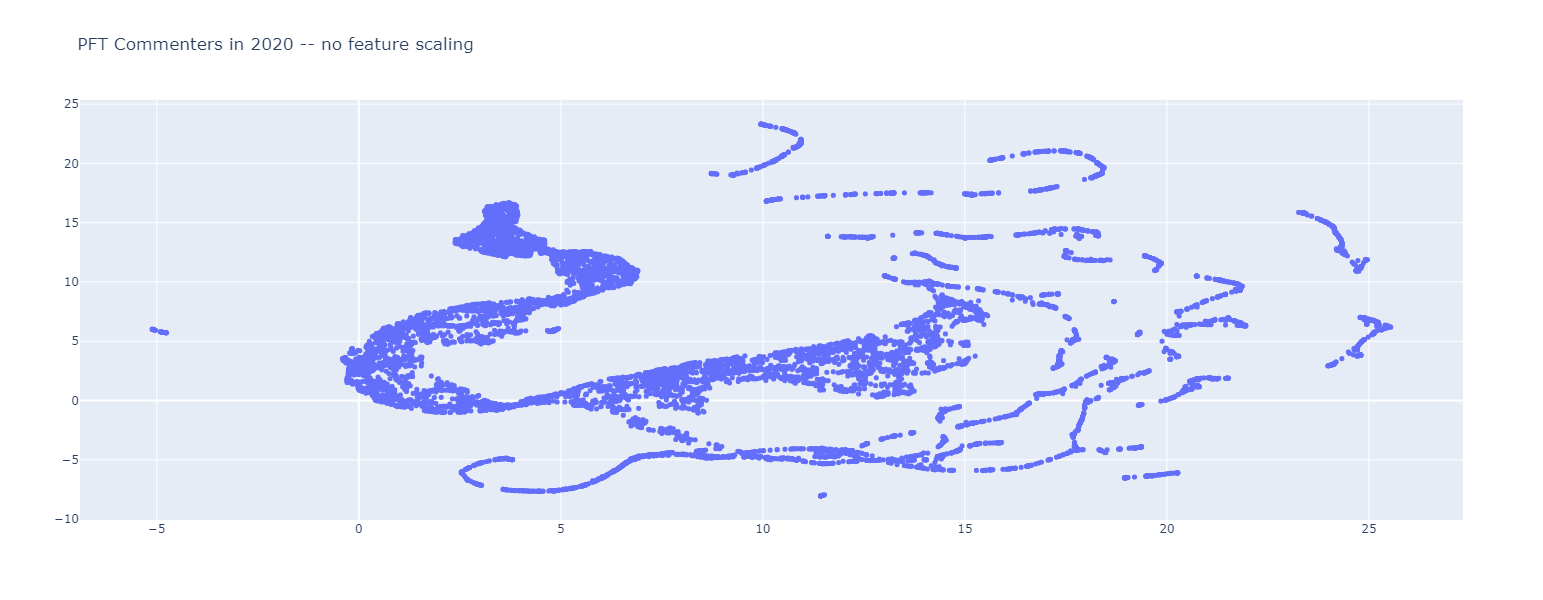

In [167]:
# Reduce dimensionality (using UMAP)
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(df_rescaled)

# Visualize 2-dimensional data
fig = go.Figure(data=go.Scatter(x=embedding[:, 0], y=embedding[:, 1], mode='markers', marker=dict(size=5)))
fig.update_layout(title='PFT Commenters in 2020 -- no feature scaling')
fig.update_layout(height=600, width=600)
fig.show()

### Cluster data using DBSCAN

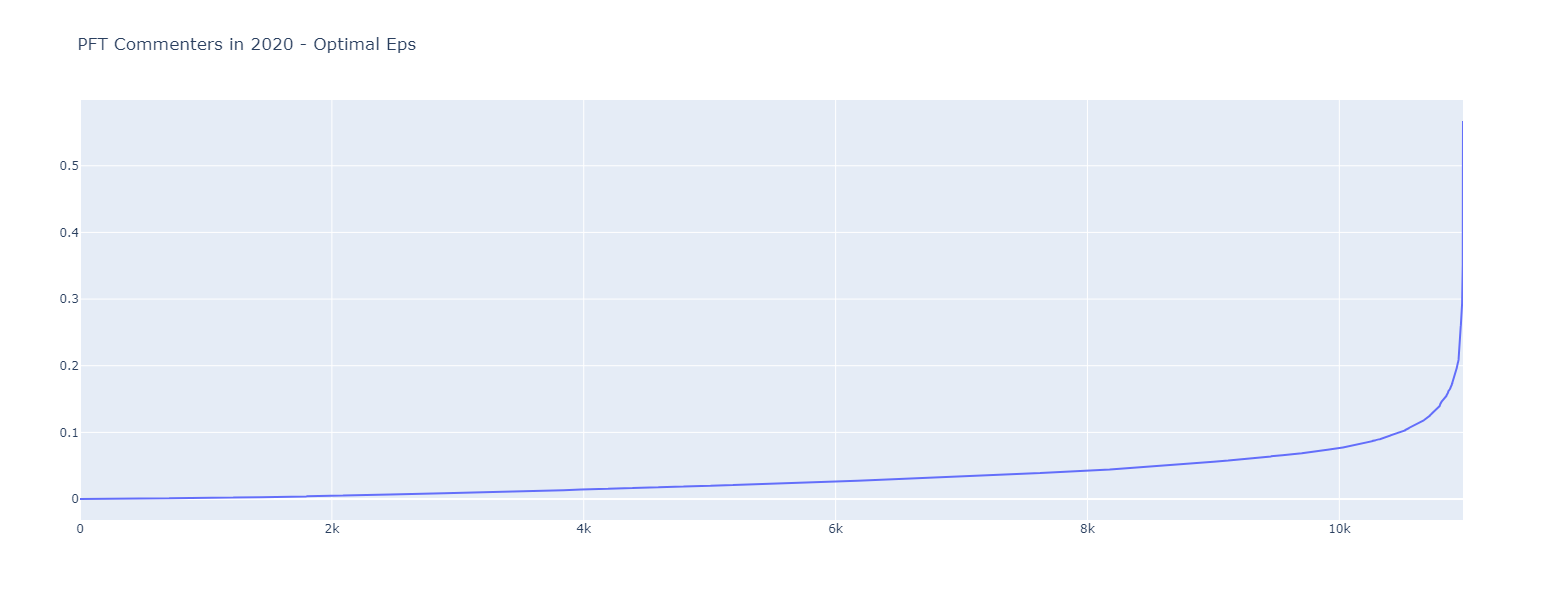

In [168]:
# Check for an optimal eps value
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(embedding)
distances, indices = nbrs.kneighbors(embedding)
distances = np.sort(distances, axis=0)
# distances = distances[:,1]
fig = go.Figure(data=go.Scatter(y=distances[:,1], mode='lines', marker=dict(size=5)))
fig.update_layout(title='PFT Commenters in 2020 - Optimal Eps')
fig.update_layout(height=600, width=600)
fig.show()

In [185]:
# Cluster
model = DBSCAN(eps=0.5, min_samples=100, n_jobs=-1)
yhat = model.fit_predict(embedding)
clusters = np.unique(yhat)
print('Clustering Complete')

Clustering Complete


In [190]:
# Combine DR'ed and cluster assignments
embedding_df = pd.DataFrame(embedding)
embedding_df.columns = [0, 1]
embedding_df['cluster'] = yhat
cluster_distribution = embedding_df.groupby(['cluster']).size().reset_index()
cluster_distribution.columns = ['cluster','cluster_size']
cluster_distribution

cluster  cluster_size
0        -1          3214
1         0          3764
2         1           353
3         2          1234
4         3           518
5         4           713
6         5           267
7         6           139
8         7           147
9         8           111
10        9           222
11       10           186
12       11           115

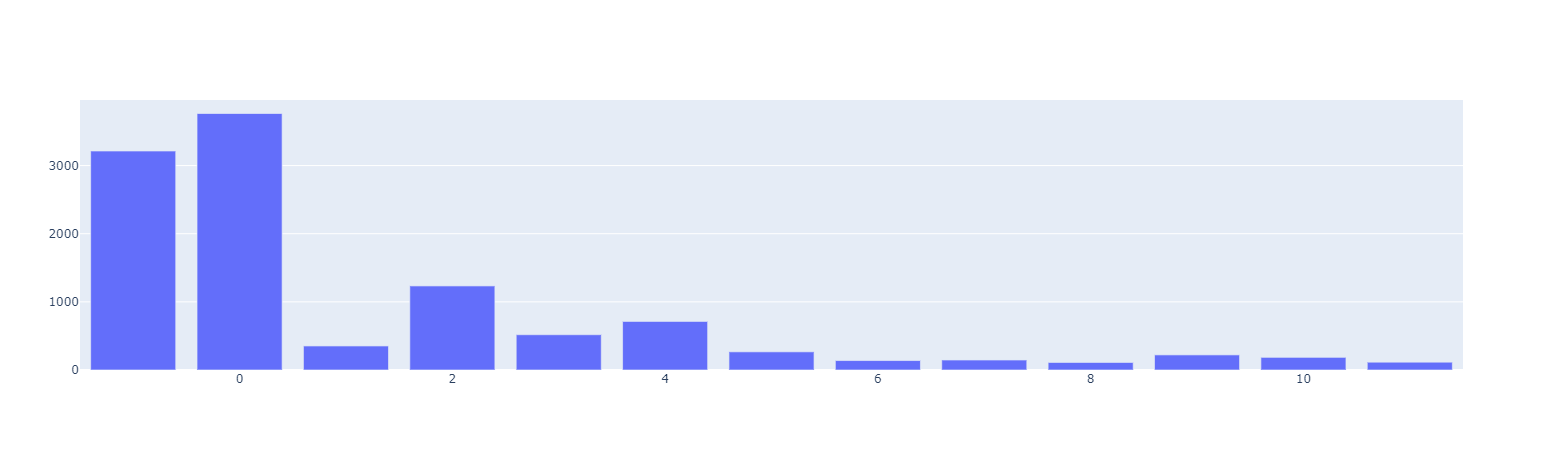

In [191]:
# Visualize the distribution of commentors by clusters
fig = go.Figure()
fig.add_trace(go.Bar(x=cluster_distribution.cluster, y=cluster_distribution.cluster_size))
fig.show()

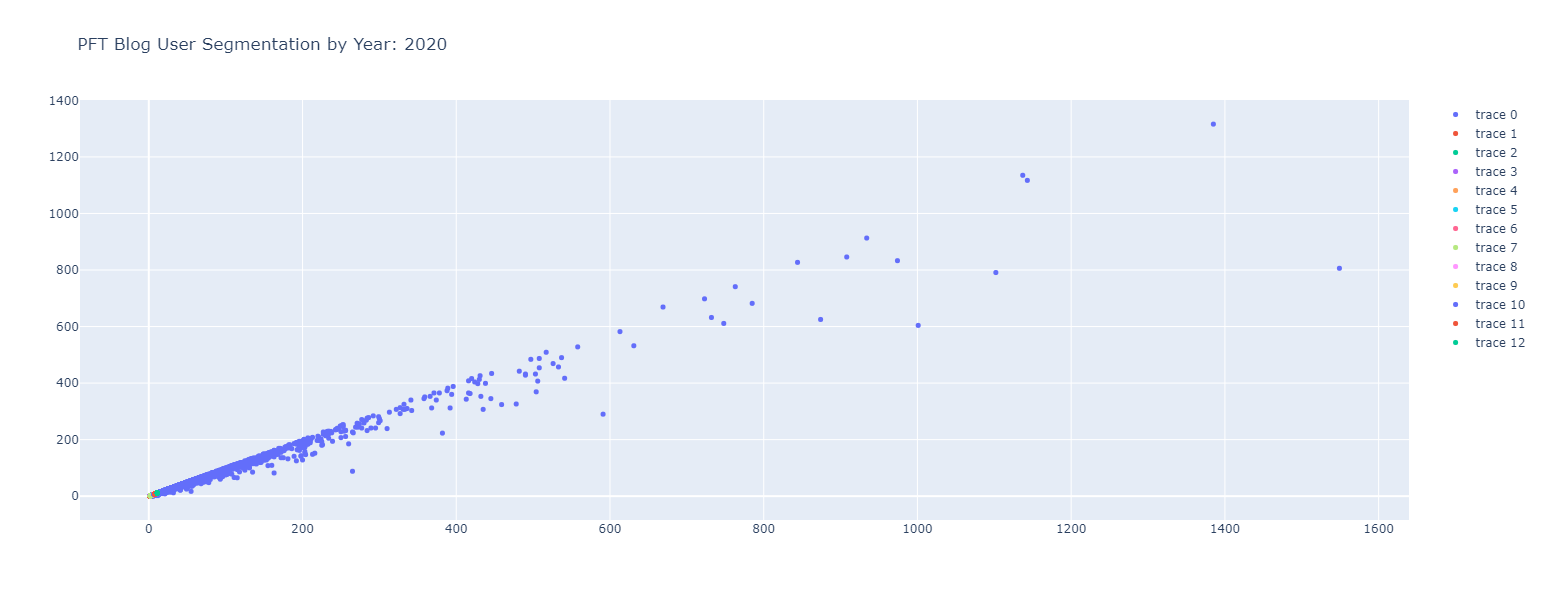

In [192]:
# Visualize clusters
fig = go.Figure()
for c in embedding_df.cluster.unique():
    df_plot = embedding_df[embedding_df.cluster == c]
    fig.add_trace(go.Scatter(x=df_plot[0], y=df_plot[1], mode='markers', marker=dict(size=5)))
    
fig.update_layout(height=600, width=600, title_text=f"PFT Blog User Segmentation by Year: 2020")
fig.show()

# visualize results

# fig.update_layout(showlegend=False)
# fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=False)
# fig.update_xaxes(range=[-20, 20])
# fig.update_yaxes(range=[-20, 20])

### Determine dominant features of clusters

In [241]:
# determine 
df['cluster'] = yhat
mean_features_by_cluster = df.groupby(['cluster']).agg({
                            'commentor_activity_duration_in_days':['mean'],
                            'num_char_total':['mean'],
                            'num_char_mean':['mean'],
                            'unique_articles_commented_on':['mean'],
                            'comments_made_during_afternoon':['mean'],
                            'comments_made_during_evening':['mean'],
                            'comments_made_during_morning':['mean'],
                            'comments_made_during_night':['mean'],
                            'num_comments':['mean'],
                            'number_of_articles_w_more_than_one_comment':['mean']})
mean_features_by_cluster = mean_features_by_cluster.droplevel(level=1, axis=1)

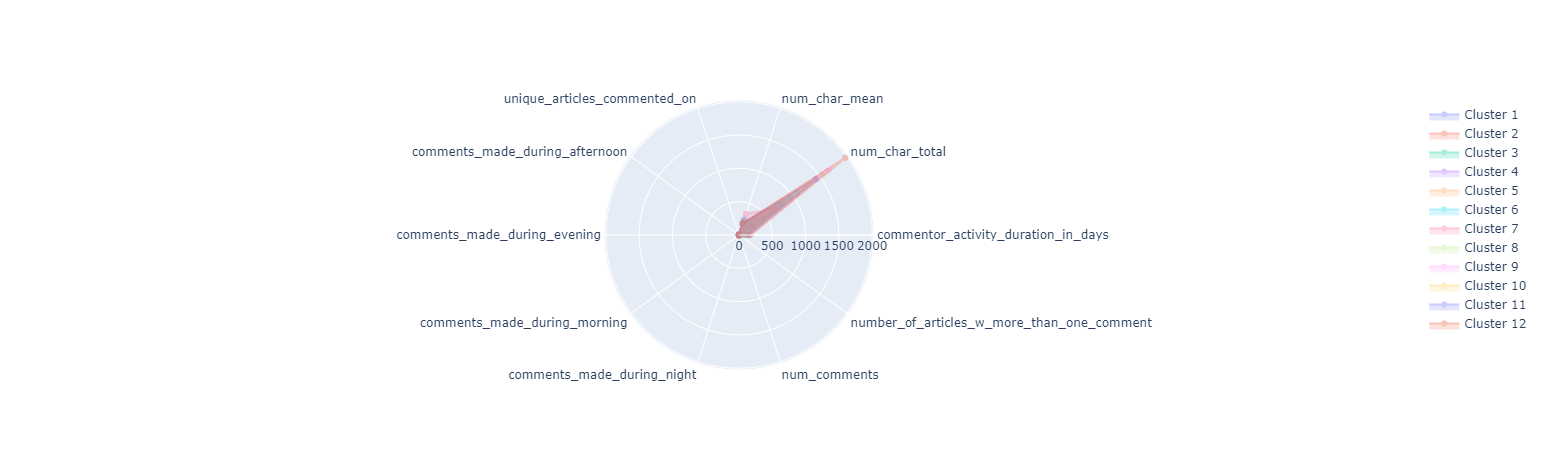

In [243]:
categories = mean_features_by_cluster.columns

fig = go.Figure()
for row in range(1, mean_features_by_cluster.shape[0]):
    fig.add_trace(go.Scatterpolar(
      r=mean_features_by_cluster.iloc[row, :].values,
      theta=categories,
      fill='toself',
      name=f'Cluster {row}',
      opacity=.35
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True)),
    showlegend=True)

fig.show()